# Neurog Internship: (Task 2 - Vizualization & Implementation of Technical Indicators)

## All Libraries

In [277]:
# For Vizualization & Plotting
from matplotlib.dates import DateFormatter
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import mplfinance as mpf

# Library For Technical Analysis
from ta.trend import IchimokuIndicator
from ta.momentum import RSIIndicator
from ta.trend import PSARIndicator
from ta.trend import ADXIndicator

# Other Necessary Libraries
import pandas as pd
import copy

## All Declarations

In [ ]:
# Define the relative path to the CSV file
csv_filename = "BTCUSDT_1_Minute_From_2020_To_Latest_Filtered.csv"

# Settig Up The Directory From The Directory Hierarchy
# Get the notebook's current directory
notebook_dir = os.path.dirname(os.path.abspath(__file__))

# Go up one level to the parent directory
parent_dir = os.path.dirname(script_dir)

# Create the full path to the output CSV file in the 'ohlc' directory within 'data'
data_dir = os.path.join(parent_dir, "data")
ohlc_dir = os.path.join(data_dir, "ohlc")
full_csv_path = os.path.join(ohlc_dir, csv_filename)

## (Function To Convert DF To Any Timeframe) - Taken From The Previous Day

In [169]:
# Functions converts the dataframe into any given time frame.
def convert_1m_to_any_timeframe(df: pd.DataFrame, timeframe: str) -> pd.DataFrame:
    """
    Convert a DataFrame of 1-minute OHLC data to any given timeframe.

    Args:
    - df (pd.DataFrame): DataFrame containing 1-minute OHLC data. 
      The DataFrame should have a datetime index & columns ['Open', 'High', 'Low', 'Close', 'Volume'].
    - timeframe (str): The desired timeframe to resample the data to (e.g., '1H' for 1 hour, '1D' for 1 day).

    Returns:
    - pd.DataFrame: Resampled DataFrame with OHLC data in the specified timeframe. The index will be renamed to
      reflect the new timeframe.

    Example:
    ```
    resampled_df = convert_1m_to_any_timeframe(ohlc_df, '1H')
    ```
    """
    # Ensure the DataFrame index is of datetime type
    df.index = pd.to_datetime(df.index)
    
    # Try resampling the data to the desired timeframe
    try:
        df_resampled = df.resample(timeframe).agg({
            'Open': 'first',  # Take the first 'Open' value in the timeframe
            'High': 'max',    # Take the maximum 'High' value in the timeframe
            'Low': 'min',     # Take the minimum 'Low' value in the timeframe
            'Close': 'last',  # Take the last 'Close' value in the timeframe
            'Volume': 'mean'  # Take the mean 'Volume' value in the timeframe
        })
    except Exception as e:
        print(f"An error occurred while resampling! Error message: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

    # Rename the index to reflect the new timeframe
    df_resampled.index.rename(f'Open time ({timeframe})', inplace = True)
    
    return df_resampled

## Vizualization & Plotting Functions

In [285]:
# Function For Plotting Candlestick manually
def plot_candlestick_chart(df: pd.DataFrame, interval: str = '1-Month'):
    """
    Plot a candlestick chart for BTCUSDT data.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Open', 'High', 'Low', 'Close' columns.
    - interval (str): The time interval of the data (default is '1-Month').

    Returns:
    - None: Displays the plot.
    """
    # Prepare data for the candlestick chart
    df = df[['Open', 'High', 'Low', 'Close']]
    df['Date'] = df.index.map(date2num)

    # Plot the candlestick chart
    fig, ax = plt.subplots(figsize=(15, 7))
    candlestick_data = df[['Date', 'Open', 'High', 'Low', 'Close']].values

    # Candlestick plot
    for date, open, high, low, close in candlestick_data:
        color = 'green' if close >= open else 'red'
        ax.plot([date, date], [low, high], color='black')
        ax.plot([date, date], [open, close], color=color, linewidth=6)

    # Formatting the date axis
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.xticks(rotation=45)

    plt.title(f'BTCUSDT Candlestick Chart ({interval} Interval)')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.grid(True)
    plt.show()
    

# Plotting Function For RSI   
def plot_rsi_with_signals(df: pd.DataFrame):
    """
    Plot RSI with signals for buying and selling.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close', 'RSI', and 'Signal' columns.

    Returns:
    - None: Displays the plot.
    """
    plt.figure(figsize=(24, 12))

    # Plot RSI
    plt.subplot(2, 1, 1)
    plt.plot(df.index, df['RSI'], label='RSI', color='blue', linewidth = 0.17)
    plt.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
    plt.axhline(y=30, color='g', linestyle='--', label='Oversold (30)')
    plt.title('Relative Strength Index (RSI)')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Plot signals
    plt.subplot(2, 1, 2)
    plt.plot(df.index, df['Close'], label='Close Price', color='black', alpha=0.9, linewidth = 0.28)
    buy_signals = df[df['Signal'] == 1]
    sell_signals = df[df['Signal'] == -1]
    if not buy_signals.empty:
        plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', s = 8.5, color='green', label='Buy Signal')
    if not sell_signals.empty:
        plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', s = 8.5, color='red', label='Sell Signal')

    plt.title('RSI Buy/Sell Signals')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    

# Plotting Function For MACD
def plot_macd_with_signals(df: pd.DataFrame):
    """
    Plot the MACD line, Signal line, EMA_12, and EMA_26 along with buy/sell signals.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', and 'MACD_Signal' values.
    """
    plt.figure(figsize=(14, 12))
    
    # Plot the closing price and EMAs
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df['Close'], label='Close Price', color='black', alpha=0.7)
    plt.plot(df.index, df['EMA_12'], label='EMA 12', color='blue', alpha=0.7)
    plt.plot(df.index, df['EMA_26'], label='EMA 26', color='red', alpha=0.7)
    plt.title('BTCUSDT Close Price and EMAs')
    plt.legend(loc='upper left')  # Specify the legend location

    # Plot the MACD and Signal line
    plt.subplot(3, 1, 2)
    plt.plot(df.index, df['MACD'], label='MACD', color='green', alpha=0.7)
    plt.plot(df.index, df['Signal_Line'], label='Signal Line', color='orange', alpha=0.7)
    plt.title('BTCUSDT MACD and Signal Line')
    plt.legend(loc='upper left')  # Specify the legend location

    # Plot MACD signals
    plt.subplot(3, 1, 3)
    plt.plot(df.index, df['MACD'], label='MACD', color='green', alpha=0.7)
    plt.plot(df.index, df['Signal_Line'], label='Signal Line', color='orange', alpha=0.7)

    # Highlight buy signals
    buy_signals = df[df['MACD_Signal'] == 1].index
    for buy in buy_signals:
        plt.axvline(x=buy, color='blue', linestyle='--', lw=0.5, alpha=0.7)
    
    # Highlight sell signals
    sell_signals = df[df['MACD_Signal'] == -1].index
    for sell in sell_signals:
        plt.axvline(x=sell, color='red', linestyle='--', lw=0.5, alpha=0.7)

    plt.title('BTCUSDT MACD Buy/Sell Signals')
    plt.legend(loc='upper left')  # Specify the legend location

    plt.tight_layout()
    plt.show()
    
    
# Plotting Function For ADX & Parabolic SAR
def plot_adx_parabolic_sar_signals(df: pd.DataFrame):
    """
    Plot ADX and Parabolic SAR with buy/sell signals.
    
    Args:
    - df (pd.DataFrame): DataFrame containing 'Close', 'ADX', 'Parabolic_SAR', and 'Signal' columns.
    """
    plt.figure(figsize=(14, 10))

    # Plot the closing price and Parabolic SAR
    plt.subplot(2, 1, 1)
    plt.plot(df.index, df['Close'], label='Close Price', color='black', alpha=0.7)
    plt.plot(df.index, df['Parabolic_SAR'], label='Parabolic SAR', color='green', alpha=0.7, linestyle='--')
    plt.title('BTCUSDT Close Price and Parabolic SAR')
    plt.legend(loc='upper left')

    # Plot ADX
    plt.subplot(2, 1, 2)
    plt.plot(df.index, df['ADX'], label='ADX', color='blue', alpha=0.7)
    plt.axhline(y=25, color='red', linestyle='--', lw=1)
    plt.title('BTCUSDT ADX')
    plt.legend(loc='upper left')

    # Highlight buy signals
    buy_signals = df[df['Signal'] == 1].index
    for buy in buy_signals:
        plt.axvline(x=buy, color='blue', linestyle='--', lw=0.5, alpha=0.7)
    
    # Highlight sell signals
    sell_signals = df[df['Signal'] == -1].index
    for sell in sell_signals:
        plt.axvline(x=sell, color='red', linestyle='--', lw=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()


# Plotting Function For OBV
def plot_obv_with_signals(df: pd.DataFrame):
    """
    Plot On-Balance Volume (OBV) with signals for buying and selling.

    Args:
    - df (pd.DataFrame): DataFrame containing 'OBV' and 'Signal' columns.

    Returns:
    - None: Displays the plot.
    """
    # Initialize the figure
    plt.figure(figsize=(14, 7))

    # Plot OBV
    plt.plot(df.index, df['OBV'], label='OBV', color='blue')

    # Plot signals
    buy_signals = df[df['Signal'] == 1]
    sell_signals = df[df['Signal'] == -1]

    if not buy_signals.empty:
        plt.scatter(buy_signals.index, buy_signals['OBV'], marker='|', s = 500, linewidth = 0.35, color='green', label='Buy Signal')
    if not sell_signals.empty:
        plt.scatter(sell_signals.index, sell_signals['OBV'], marker='|', s = 500, linewidth = 0.35, color='red', label='Sell Signal')

    # Add title and labels
    plt.title('On-Balance Volume (OBV) with Signals')
    plt.xlabel('Date')
    plt.ylabel('OBV')

    # Add legend
    plt.legend()

    # Display grid
    plt.grid(True)

    # Show plot
    plt.tight_layout()
    plt.show()
    
    
# Plotting Function For Ichimoku Cloud
def plot_ichimoku_cloud(df: pd.DataFrame):
    """
    Plot Ichimoku Cloud components.

    Args:
    - df (pd.DataFrame): DataFrame containing Ichimoku Cloud components.

    Returns:
    - None: Displays the plot.
    """
    # Plotting Ichimoku Cloud
    plt.figure(figsize=(14, 7))

    # Plot Close Price
    plt.plot(df.index, df['Close'], label='Close', color='black')

    # Plot Ichimoku Components
    plt.plot(df.index, df['Tenkan_Sen'], label='Conversion Line (Tenkan-sen)', color='blue')
    plt.plot(df.index, df['Kijun_Sen'], label='Base Line (Kijun-sen)', color='orange')
    plt.plot(df.index, df['Senkou_Span_A'], label='Leading Span A (Senkou Span A)', color='green', alpha=0.5)
    plt.plot(df.index, df['Senkou_Span_B'], label='Leading Span B (Senkou Span B)', color='red', alpha=0.5)
    plt.plot(df.index, df['Chikou_Span'], label='Lagging Span (Chikou Span)', color='purple')

    # Fill Cloud
    plt.fill_between(df.index, df['Senkou_Span_A'], df['Senkou_Span_B'], where=df['Senkou_Span_A'] >= df['Senkou_Span_B'], color='green', alpha=0.2)
    plt.fill_between(df.index, df['Senkou_Span_A'], df['Senkou_Span_B'], where=df['Senkou_Span_A'] < df['Senkou_Span_B'], color='red', alpha=0.2)

    # Customize plot
    plt.title('Ichimoku Cloud')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## RSI Indicator Function

In [281]:
def calculate_rsi(df: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate the Relative Strength Index (RSI) using the ta library.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - window (int): The window size for calculating RSI, default is 14.

    Returns:
    - pd.DataFrame: DataFrame with the RSI values.
    """
    # Calculate RSI using ta library
    rsi_indicator = RSIIndicator(close=df['Close'], window=window, fillna=True)
    df['RSI'] = rsi_indicator.rsi()

    return df

def generate_signals(df: pd.DataFrame, rsi_lower: int = 20, rsi_upper: int = 80) -> pd.DataFrame:
    """
    Generate trading signals based on RSI values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'RSI' values.
    - rsi_lower (int): RSI lower threshold for buy signals, default is 30.
    - rsi_upper (int): RSI upper threshold for sell signals, default is 70.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    df['Signal'] = 0  # Default no signal
    df.loc[df['RSI'] > rsi_upper, 'Signal'] = -1  # Sell signal
    df.loc[df['RSI'] < rsi_lower, 'Signal'] = 1   # Buy signal

    return df

## MACD Indicator Function

In [234]:
def calculate_macd(df: pd.DataFrame, short_window: int = 12, long_window: int = 26, signal_window: int = 9) -> pd.DataFrame:
    """
    Calculate the MACD (Moving Average Convergence Divergence) for a given DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - short_window (int): The window size for the short-term EMA, default is 12.
    - long_window (int): The window size for the long-term EMA, default is 26.
    - signal_window (int): The window size for the Signal line, default is 9.

    Returns:
    - pd.DataFrame: DataFrame with the MACD line and Signal line.
    """
    # Calculate the short-term and long-term EMAs
    df['EMA_12'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=long_window, adjust=False).mean()

    # Calculate the MACD line
    df['MACD'] = df['EMA_12'] - df['EMA_26']

    # Calculate the Signal line
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    return df

def generate_macd_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate trading signals based on MACD values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'MACD' and 'Signal_Line' values.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    df['MACD_Signal'] = 0  # Default no signal
    df.loc[df['MACD'] > df['Signal_Line'], 'MACD_Signal'] = 1  # Buy signal
    df.loc[df['MACD'] < df['Signal_Line'], 'MACD_Signal'] = -1  # Sell signal

    return df

## ADX In Combination With Parabolic SAR Indicator Function

In [235]:
def calculate_adx(df: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate the Average Directional Index (ADX) and add it to the DataFrame.
    
    Args:
    - df (pd.DataFrame): DataFrame containing 'High', 'Low', and 'Close' columns.
    - window (int): Window size for the ADX calculation (default is 14).
    
    Returns:
    - df (pd.DataFrame): DataFrame with added 'ADX' column.
    """
    adx = ADXIndicator(df['High'], df['Low'], df['Close'], window=window)
    df['ADX'] = adx.adx()
    df['DI+'] = adx.adx_pos()
    df['DI-'] = adx.adx_neg()
    return df

def calculate_parabolic_sar(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the Parabolic SAR and add it to the DataFrame.
    
    Args:
    - df (pd.DataFrame): DataFrame containing 'High', 'Low', and 'Close' columns.
    
    Returns:
    - df (pd.DataFrame): DataFrame with added 'Parabolic_SAR' column.
    """
    psar = PSARIndicator(df['High'], df['Low'], df['Close'])
    df['Parabolic_SAR'] = psar.psar()
    return df

def generate_adx_parabolic_sar_signals(df: pd.DataFrame, adx_threshold: float = 25) -> pd.DataFrame:
    """
    Generate trading signals based on ADX and Parabolic SAR.

    Args:
    - df (pd.DataFrame): DataFrame containing 'ADX' and 'Parabolic_SAR' columns.
    - adx_threshold (float): Threshold for ADX to consider a strong trend (default is 25).

    Returns:
    - df (pd.DataFrame): DataFrame with added 'Signal' column (1 for buy, -1 for sell, 0 for hold).
    """
    df['Signal'] = 0  # Default to hold
    df.loc[(df['ADX'] > adx_threshold) & (df['Close'] > df['Parabolic_SAR']), 'Signal'] = 1  # Buy signal
    df.loc[(df['ADX'] > adx_threshold) & (df['Close'] < df['Parabolic_SAR']), 'Signal'] = -1  # Sell signal
    return df

## On-Balance Volume (OBV) Indicator Function

In [238]:
def generate_obv_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate trading signals based on On-Balance Volume (OBV) indicator.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' and 'Volume' columns.

    Returns:
    - df (pd.DataFrame): DataFrame with added 'OBV' and 'Signal' columns.
    """
    df['OBV'] = 0  # Initialize OBV column with zeros
    df['Signal'] = 0  # Initialize Signal column with zeros

    # Calculate OBV values
    for i in range(1, len(df)):
        if df['Close'].iloc[i] > df['Close'].iloc[i - 1]:
            df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1] + df['Volume'].iloc[i]
        elif df['Close'].iloc[i] < df['Close'].iloc[i - 1]:
            df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1] - df['Volume'].iloc[i]
        else:
            df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1]

    # Generate signals based on OBV
    df.loc[df['OBV'] > df['OBV'].shift(1), 'Signal'] = 1  # Buy signal
    df.loc[df['OBV'] < df['OBV'].shift(1), 'Signal'] = -1  # Sell signal

    return df

## Ichimoku Cloud Calculator Function

In [264]:
def calculate_ichimoku_cloud(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate Ichimoku Cloud components using the ta library.

    Args:
    - df (pd.DataFrame): DataFrame containing 'High', 'Low', and 'Close' columns.

    Returns:
    - pd.DataFrame: DataFrame with Ichimoku Cloud components.
    """
    # Calculate Ichimoku Cloud using ta library
    indicator = IchimokuIndicator(high=df['High'], low=df['Low'], window1=9, window2=26, window3=52, visual=False, fillna=True)
    df['Tenkan_Sen'] = indicator.ichimoku_conversion_line()
    df['Kijun_Sen'] = indicator.ichimoku_base_line()
    df['Senkou_Span_A'] = indicator.ichimoku_a()
    df['Senkou_Span_B'] = indicator.ichimoku_b()
    
    # Calculate Chikou Span manually
    df['Chikou_Span'] = df['Close'].shift(-26)
    
    return df

## Main

### Reading The Previously Saved Data For BTCUSDT

In [26]:
BTCUSDT_Filtered_data_1M = pd.read_csv(full_csv_path)
BTCUSDT_Filtered_data_1M.set_index('Open time (1M)', inplace = True)

# Convert the index to datetime format
BTCUSDT_Filtered_data_1M.index = pd.to_datetime(BTCUSDT_Filtered_data_1M.index)

In [27]:
BTCUSDT_Filtered_data_1M

,Open,High,Low,Close,Volume
Open time (1M),,,,,
2020-01-01 00:00:00,7169.71,7169.71,7165.44,7167.83,3509.860
2020-01-01 00:01:00,7167.83,7168.28,7158.66,7159.95,3821.170
2020-01-01 00:02:00,7161.03,7165.40,7161.03,7162.46,3041.710
2020-01-01 00:03:00,7161.74,7164.27,7160.30,7161.03,3682.650
2020-01-01 00:04:00,7161.03,7164.25,7160.15,7160.15,2936.690
...,...,...,...,...,...
2024-06-25 12:07:00,63742.80,63742.80,62743.60,62743.60,1.216
2024-06-25 12:08:00,62743.60,63742.80,62652.60,62655.00,0.726
2024-06-25 12:09:00,62655.00,63742.80,62652.60,62652.60,2.820


### Converting 1 Minute Interval Data to 1 Hour Interval Data

In [28]:
BTCUSDT_Filtered_data_1H = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '1H')
BTCUSDT_Filtered_data_1H

,Open,High,Low,Close,Volume
Open time (1H),,,,,
2020-01-01 00:00:00,7169.71,7183.07,7156.65,7174.14,3200.843000
2020-01-01 01:00:00,7173.42,7186.36,7164.51,7175.44,3262.390850
2020-01-01 02:00:00,7175.44,7188.52,7168.78,7187.44,3616.975000
2020-01-01 03:00:00,7187.20,7207.23,7181.09,7202.48,3632.039517
2020-01-01 04:00:00,7202.48,7209.48,7184.34,7195.54,3505.551667
...,...,...,...,...,...
2024-06-25 08:00:00,61965.80,63998.80,60531.00,61592.20,19.264567
2024-06-25 09:00:00,62999.70,63995.90,60608.00,61653.50,3.120217
2024-06-25 10:00:00,61302.80,63996.00,60802.00,63892.00,14.673217


### Converting 1 Minute Interval Data to 1 Day Interval Data

In [29]:
BTCUSDT_Filtered_data_1D = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '1D')
BTCUSDT_Filtered_data_1D

,Open,High,Low,Close,Volume
Open time (1D),,,,,
2020-01-01,7169.71,9592.00,6871.45,7242.21,50472.792781
2020-01-02,7242.21,7243.41,6934.53,6975.70,3348.620363
2020-01-03,6975.70,7600.00,6871.45,7342.00,3584.646061
2020-01-04,7342.00,7400.00,7260.00,7305.62,3105.244638
2020-01-05,7305.68,7492.05,7260.00,7438.62,2969.803410
...,...,...,...,...,...
2024-06-21,65788.00,71341.20,64100.00,66398.30,16.093789
2024-06-22,66494.90,67625.40,64983.20,65865.00,5.460945
2024-06-23,65806.10,65979.90,64999.50,65400.80,3.795993


### Converting 1 Minute Interval Data to 1 Month Interval Data

In [31]:
BTCUSDT_Filtered_data_1Mnth = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), 'M')
BTCUSDT_Filtered_data_1Mnth

,Open,High,Low,Close,Volume
Open time (M),,,,,
2020-01-31,7169.71,9592.00,6871.45,9317.71,3054.488504
2020-02-29,9317.72,15000.00,8165.00,8667.05,3341.226637
2020-03-31,8667.04,10690.00,3796.96,6460.79,11336.528100
2020-04-30,6460.92,9451.58,6151.01,8662.87,8265.577072
2020-05-31,8662.56,100000.00,500.00,9500.48,25293.747976
2020-06-30,9500.48,100000.00,100.00,9131.30,7448.789570
2020-07-31,9131.13,100000.00,7000.00,11350.00,289.227066
2020-08-31,11350.01,19999.00,6500.00,11716.85,169.034843
2020-09-30,11716.16,104016.00,9800.00,20000.00,169.159459


### Display Graph For Close Price (1 Day Interval)

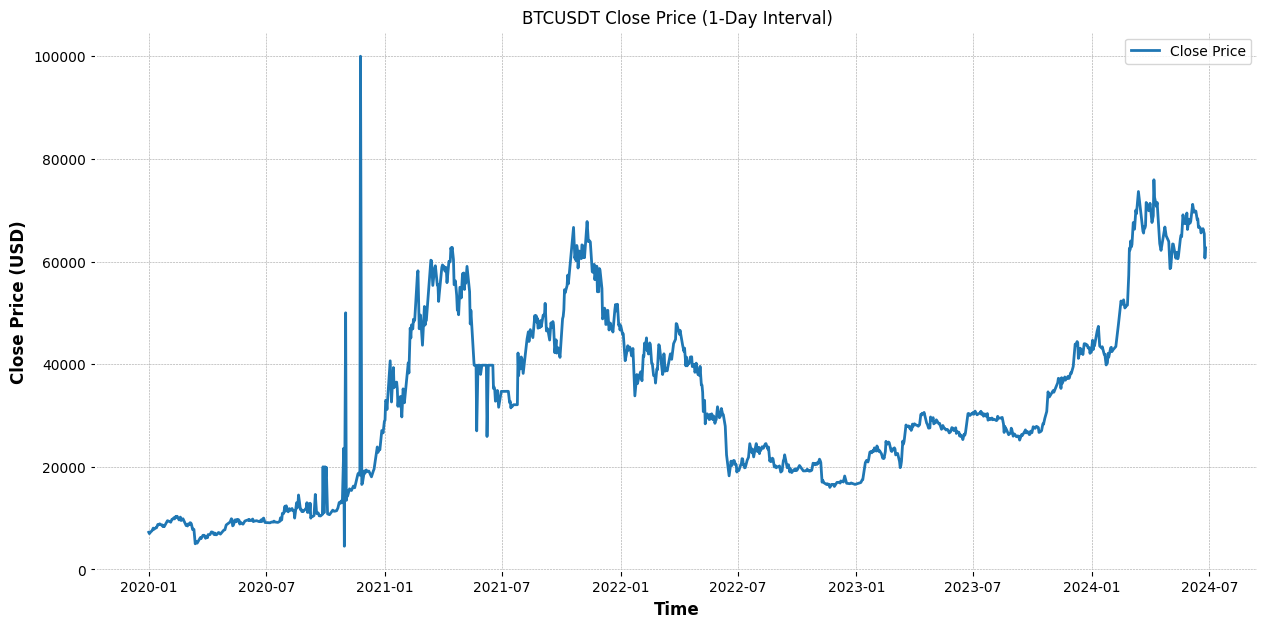

In [172]:
# Plot the 'Close' price over time
plt.figure(figsize=(15, 7))
plt.plot(BTCUSDT_Filtered_data_1D['Close'], label='Close Price')
plt.title('BTCUSDT Close Price (1-Day Interval)')
plt.xlabel('Time')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Displaying The Candle Stick Graph For BTCUSDT (1 Month Interval): Using mpf Library

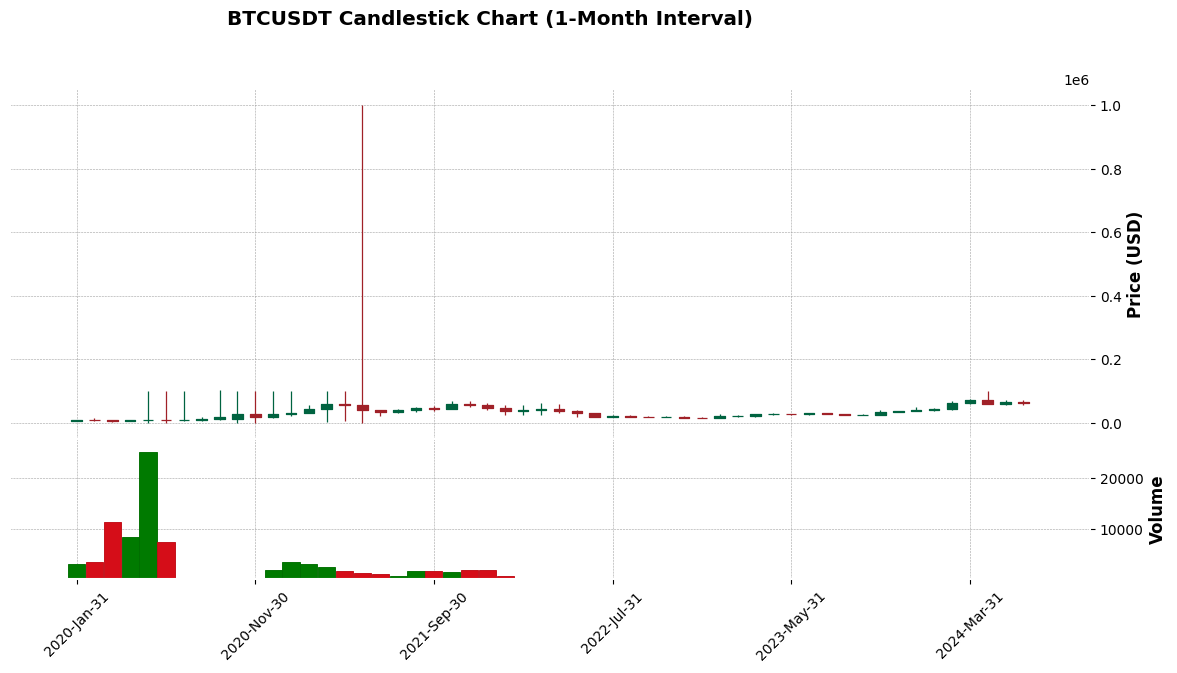

In [32]:
# Plot the candlestick chart
mpf.plot(
    BTCUSDT_Filtered_data_1Mnth,
    type='candle',
    style='charles',
    title='BTCUSDT Candlestick Chart (1-Month Interval)',
    ylabel='Price (USD)',
    volume=True,
    ylabel_lower='Volume',
    figsize=(15, 7)
)

### Displaying The Candle Stick Graph For BTCUSDT (1 Month Interval): Using matplotlib Library

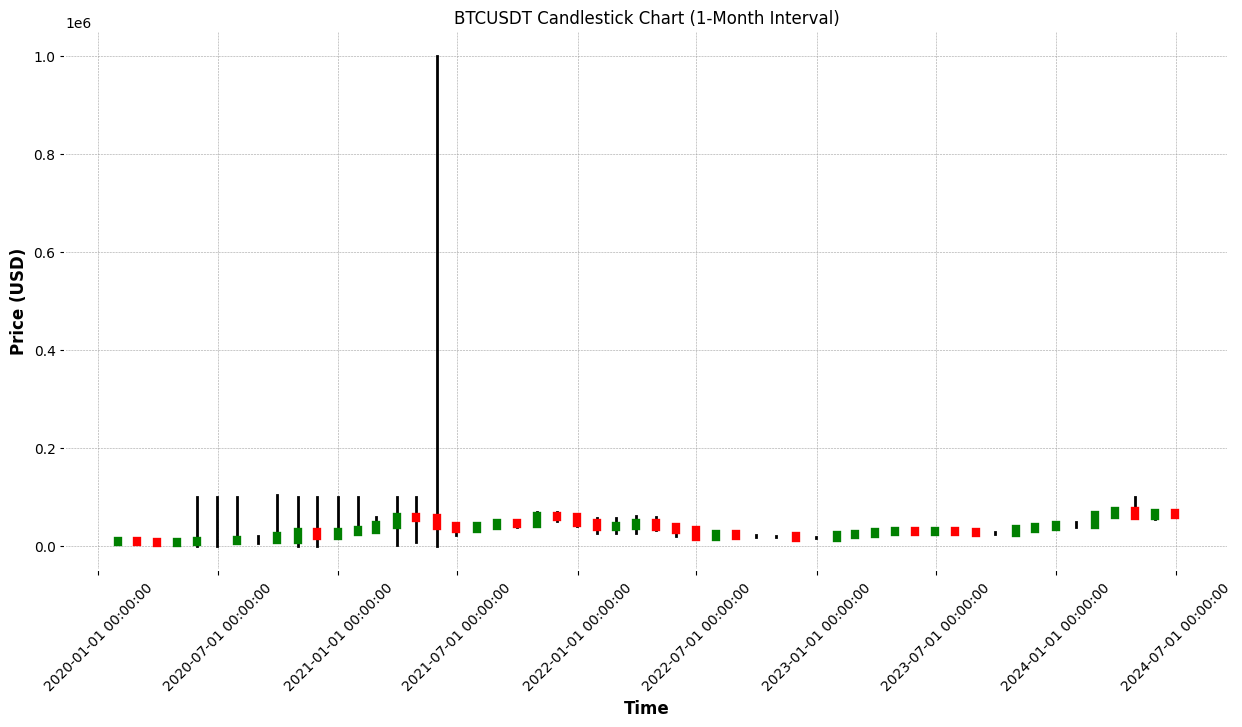

In [173]:
plot_candlestick_chart(copy.deepcopy(BTCUSDT_Filtered_data_1Mnth), interval='1-Month')

## Now, Enough Plotting! On The Task!

### Implementing The RSI Indicator & Generating Trading Signals

In [282]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_1H_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_1H))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_1H_with_rsi = generate_signals(BTCUSDT_Filtered_data_1H_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_1H_with_rsi

,Open,High,Low,Close,Volume,RSI,Signal
Open time (1H),,,,,,,
2020-01-01 00:00:00,7169.71,7183.07,7156.65,7174.14,3200.843000,100.000000,-1
2020-01-01 01:00:00,7173.42,7186.36,7164.51,7175.44,3262.390850,100.000000,-1
2020-01-01 02:00:00,7175.44,7188.52,7168.78,7187.44,3616.975000,100.000000,-1
2020-01-01 03:00:00,7187.20,7207.23,7181.09,7202.48,3632.039517,100.000000,-1
2020-01-01 04:00:00,7202.48,7209.48,7184.34,7195.54,3505.551667,78.509611,0
...,...,...,...,...,...,...,...
2024-06-25 08:00:00,61965.80,63998.80,60531.00,61592.20,19.264567,47.059843,0
2024-06-25 09:00:00,62999.70,63995.90,60608.00,61653.50,3.120217,47.561539,0
2024-06-25 10:00:00,61302.80,63996.00,60802.00,63892.00,14.673217,61.798503,0


### Just Checking What Values Have Signals

In [283]:
temp_df = BTCUSDT_Filtered_data_1H_with_rsi[BTCUSDT_Filtered_data_1H_with_rsi["Signal"].isin([1, -1])]
temp_df.sample(10)

,Open,High,Low,Close,Volume,RSI,Signal
Open time (1H),,,,,,,
2020-05-30 02:00:00,9421.00,100000.00,6500.00,9999.00,24810.652033,81.205789,-1
2020-03-12 23:00:00,6108.86,6153.38,5978.69,5988.60,16746.131383,16.320972,1
2020-11-18 06:00:00,17720.00,88888.00,17614.04,88888.00,9.255467,99.410444,-1
2020-03-08 23:00:00,8309.35,8317.21,8268.83,8294.17,9160.601333,14.980365,1
2022-03-28 01:00:00,44841.50,51500.00,35200.00,46065.10,151.633733,81.736623,-1
2020-09-27 21:00:00,11300.00,20000.00,10850.00,20000.00,13.897867,96.860793,-1
2020-05-10 08:00:00,8662.29,8671.83,8373.12,8625.13,76186.820550,12.541977,1
2020-04-02 21:00:00,6803.45,6915.81,6790.08,6915.64,5335.559917,80.059895,-1
2020-10-25 10:00:00,13296.25,13313.29,11000.00,11003.30,2.392567,12.274616,1


### Plotting The RSI Graph (Along With 80 & 20 Lines)

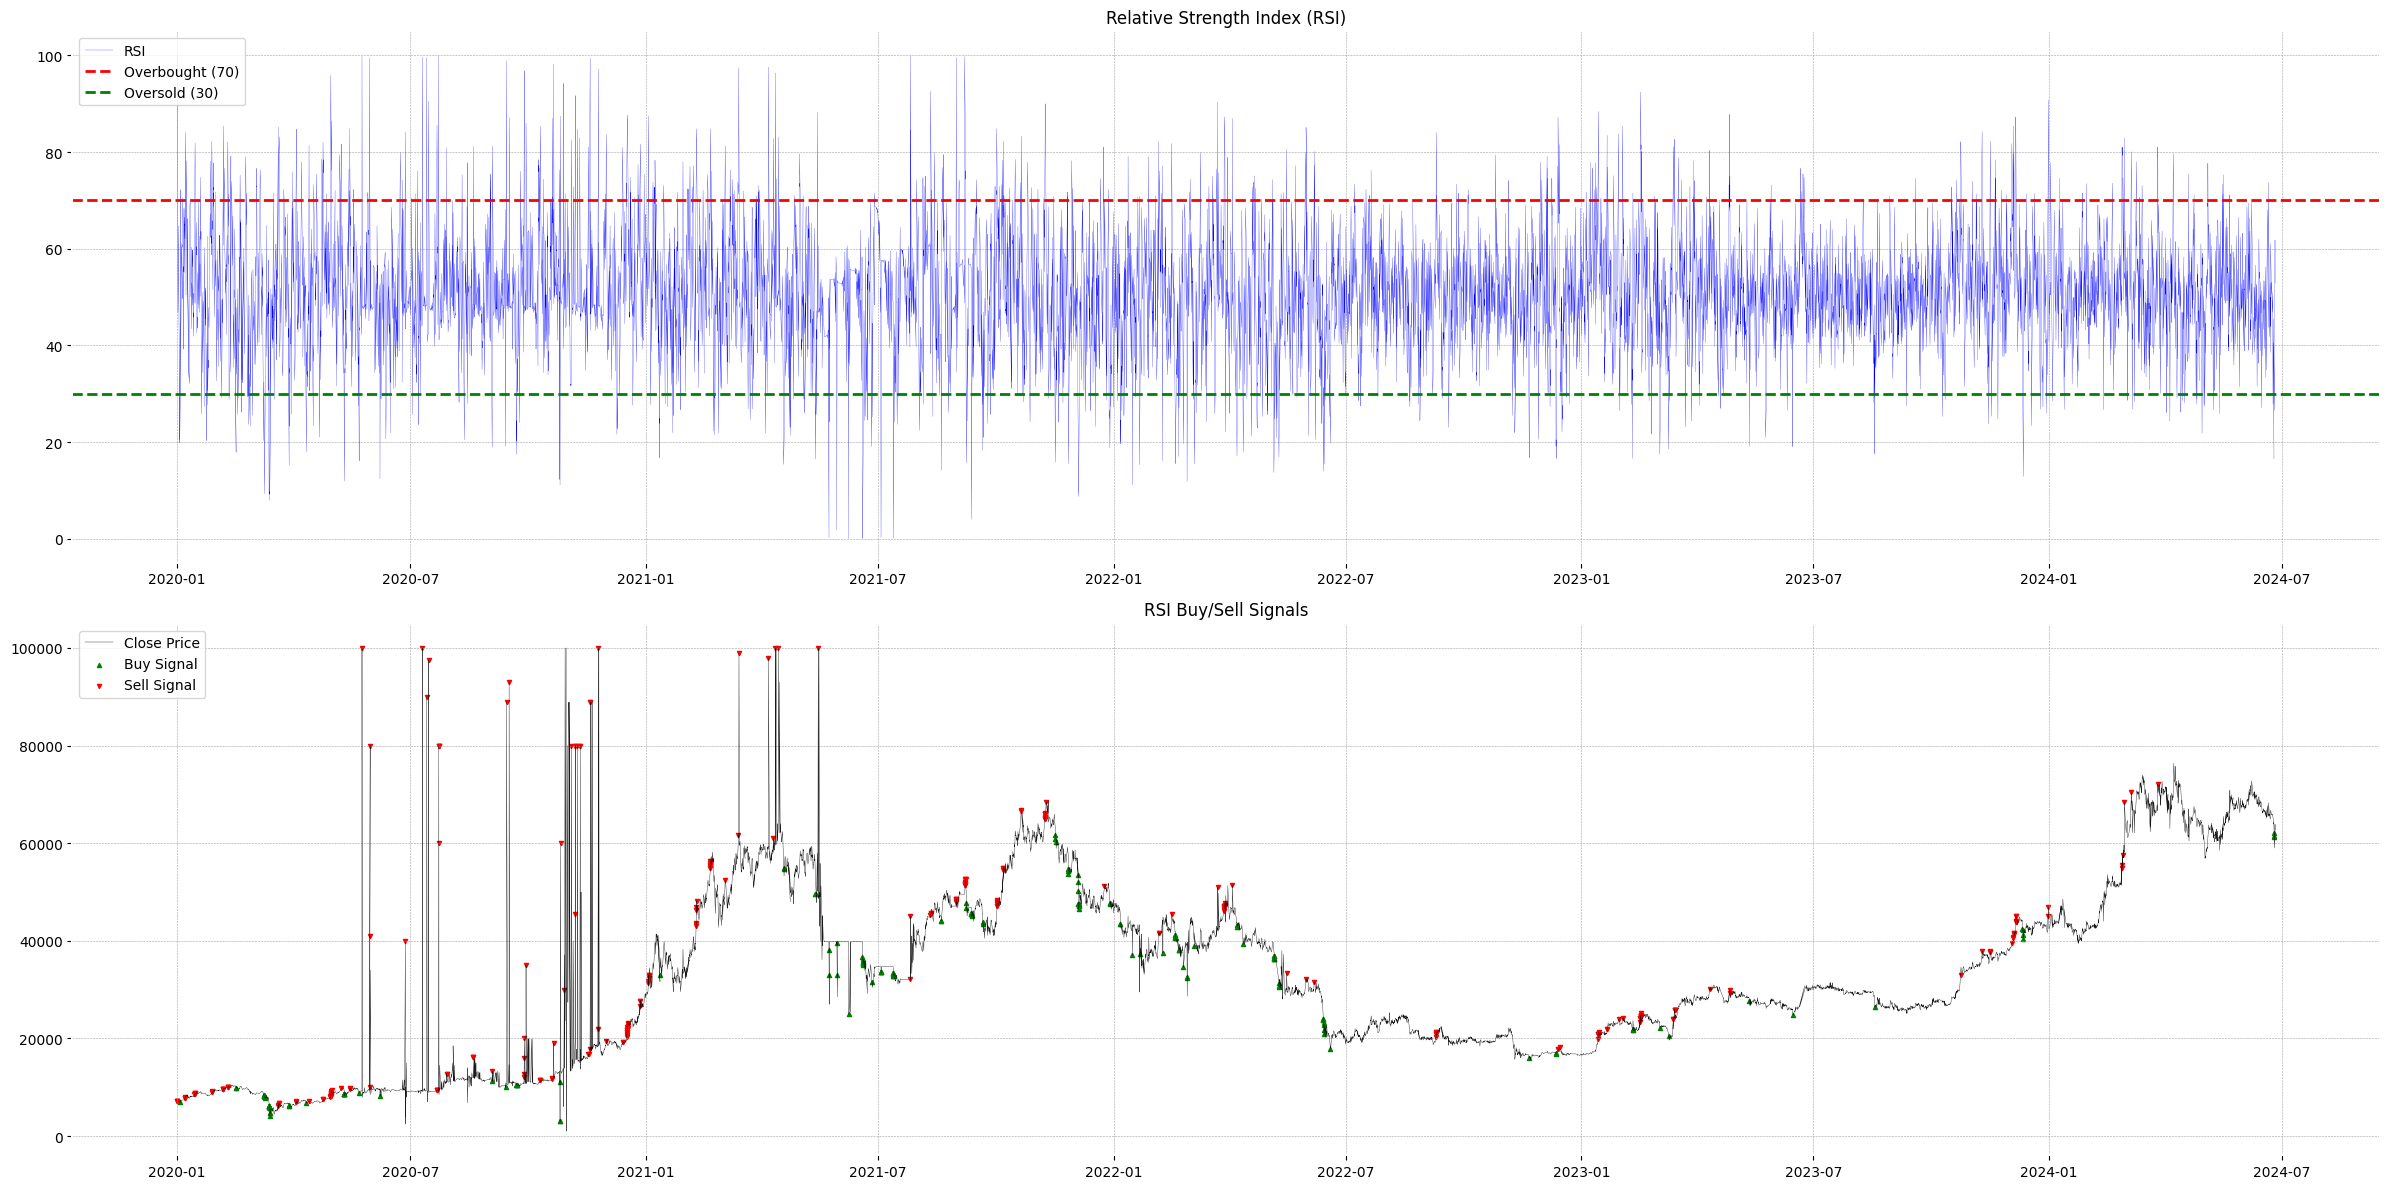

In [286]:
plot_rsi_with_signals(BTCUSDT_Filtered_data_1H_with_rsi)

### Implenting The MACD Indicator & Generating Trading Signals

In [48]:
# Calculate MACD for the 1-Day data
BTCUSDT_Filtered_data_1D_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_1D))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_1D_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_1D_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_1D_with_macd

,Open,High,Low,Close,Volume,EMA_12,EMA_26,MACD,Signal_Line,MACD_Signal
Open time (1D),,,,,,,,,,
2020-01-01,7169.71,9592.00,6871.45,7242.21,50472.792781,7242.210000,7242.210000,0.000000,0.000000,0
2020-01-02,7242.21,7243.41,6934.53,6975.70,3348.620363,7201.208462,7222.468519,-21.260057,-4.252011,-1
2020-01-03,6975.70,7600.00,6871.45,7342.00,3584.646061,7222.868698,7231.322702,-8.454004,-5.092410,-1
2020-01-04,7342.00,7400.00,7260.00,7305.62,3105.244638,7235.599668,7236.826206,-1.226538,-4.319236,1
2020-01-05,7305.68,7492.05,7260.00,7438.62,2969.803410,7266.833565,7251.773894,15.059671,-0.443454,1
...,...,...,...,...,...,...,...,...,...,...
2024-06-21,65788.00,71341.20,64100.00,66398.30,16.093789,66916.293651,67226.124278,-309.830626,127.083755,-1
2024-06-22,66494.90,67625.40,64983.20,65865.00,5.460945,66754.556167,67125.300257,-370.744091,27.518186,-1
2024-06-23,65806.10,65979.90,64999.50,65400.80,3.795993,66546.285987,66997.559498,-451.273510,-68.240154,-1


### Plotting The Necessary MACD Lines

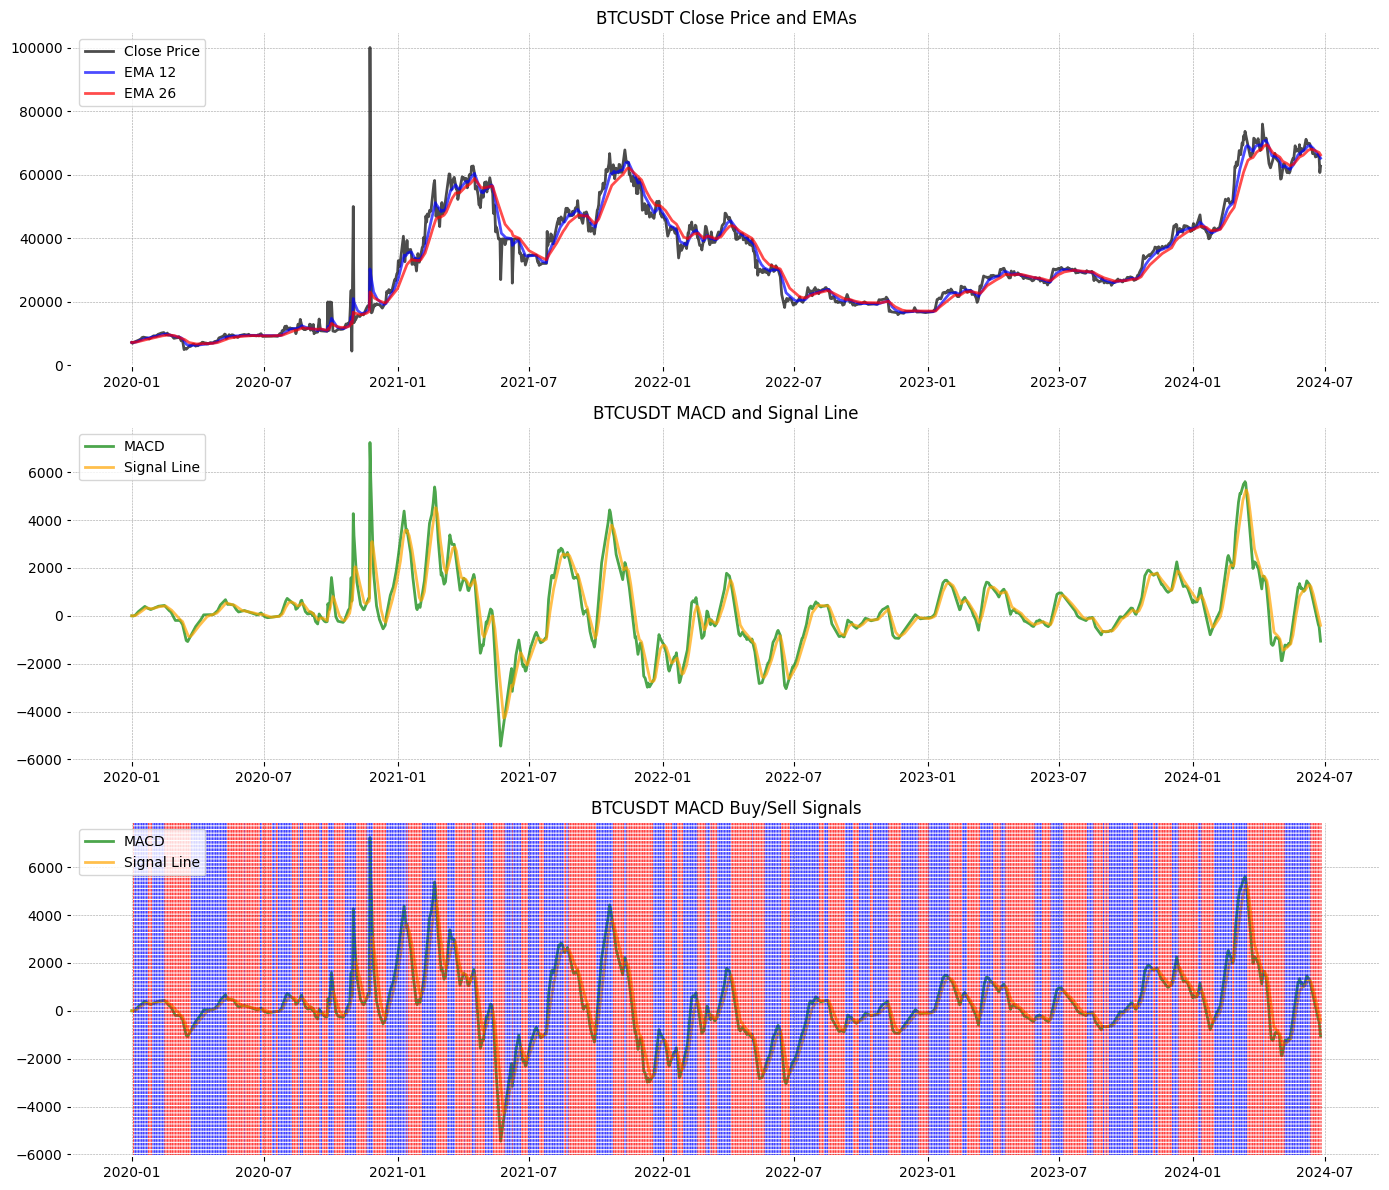

In [230]:
# Plot the MACD for 1-day data with signals
plot_macd_with_signals(BTCUSDT_Filtered_data_1D_with_macd)

### Calculating ADX & Combining Parabolic SAR To Generate Trading Signals

In [240]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_1D_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_1D))
BTCUSDT_Filtered_data_1D_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_1D_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_1D_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_1D_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_1D_with_adx_and_sar

,Open,High,Low,Close,Volume,ADX,DI+,DI-,Parabolic_SAR,Signal
Open time (1D),,,,,,,,,,
2020-01-01,7169.71,9592.00,6871.45,7242.21,50472.792781,0.000000,0.000000,0.000000,7242.210000,0
2020-01-02,7242.21,7243.41,6934.53,6975.70,3348.620363,0.000000,0.000000,0.000000,6975.700000,0
2020-01-03,6975.70,7600.00,6871.45,7342.00,3584.646061,0.000000,0.000000,0.000000,9592.000000,0
2020-01-04,7342.00,7400.00,7260.00,7305.62,3105.244638,0.000000,0.000000,0.000000,9537.589000,0
2020-01-05,7305.68,7492.05,7260.00,7438.62,2969.803410,0.000000,0.000000,0.000000,9484.266220,0
...,...,...,...,...,...,...,...,...,...,...
2024-06-21,65788.00,71341.20,64100.00,66398.30,16.093789,11.846709,15.908239,15.488771,71364.563306,0
2024-06-22,66494.90,67625.40,64983.20,65865.00,5.460945,11.095945,14.945188,14.551113,71341.200000,0
2024-06-23,65806.10,65979.90,64999.50,65400.80,3.795993,10.398807,14.592192,14.207425,71341.200000,0


### Plotting The ADX & Parabolic SAR Lines

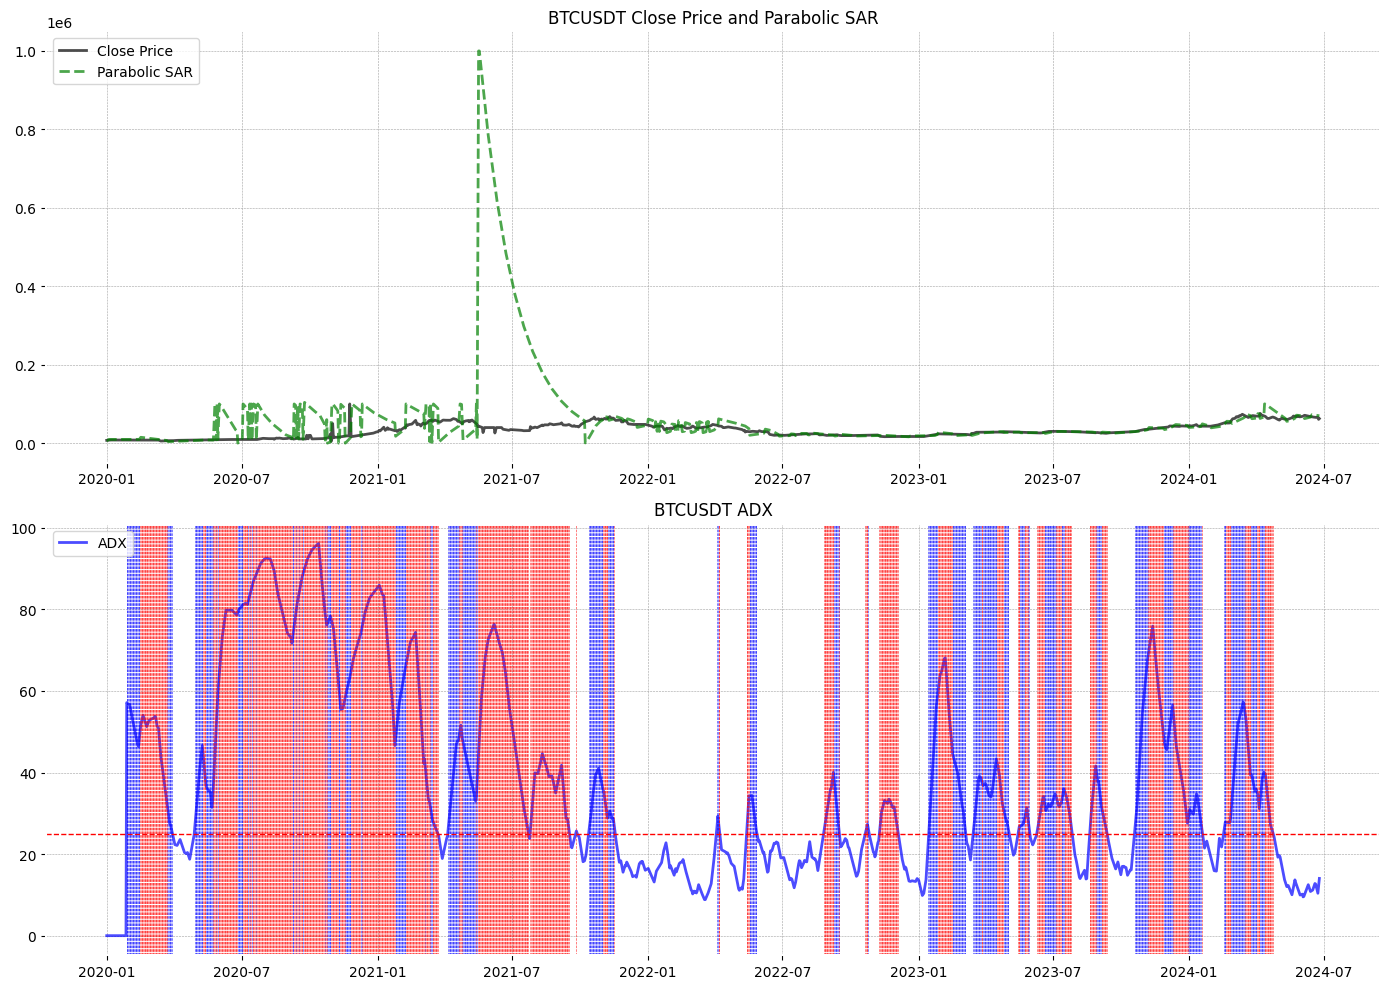

In [241]:
# Plot the results
plot_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_1D_with_adx_and_sar)

### Implementing The On-Balance Volume (OBV) Indicator Function & Generatng Trading Signals

In [90]:
# Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
BTCUSDT_Filtered_data_with_obv = generate_obv_signals(copy.deepcopy(BTCUSDT_Filtered_data_1D))
BTCUSDT_Filtered_data_with_obv

,Open,High,Low,Close,Volume,OBV,Signal
Open time (1D),,,,,,,
2020-01-01,7169.71,9592.00,6871.45,7242.21,50472.792781,0.000000,0
2020-01-02,7242.21,7243.41,6934.53,6975.70,3348.620363,-3348.620363,-1
2020-01-03,6975.70,7600.00,6871.45,7342.00,3584.646061,236.025698,1
2020-01-04,7342.00,7400.00,7260.00,7305.62,3105.244638,-2869.218940,-1
2020-01-05,7305.68,7492.05,7260.00,7438.62,2969.803410,100.584471,1
...,...,...,...,...,...,...,...
2024-06-21,65788.00,71341.20,64100.00,66398.30,16.093789,284836.531481,1
2024-06-22,66494.90,67625.40,64983.20,65865.00,5.460945,284831.070536,-1
2024-06-23,65806.10,65979.90,64999.50,65400.80,3.795993,284827.274543,-1


### Plotting The OBV Line & The Trading Signals

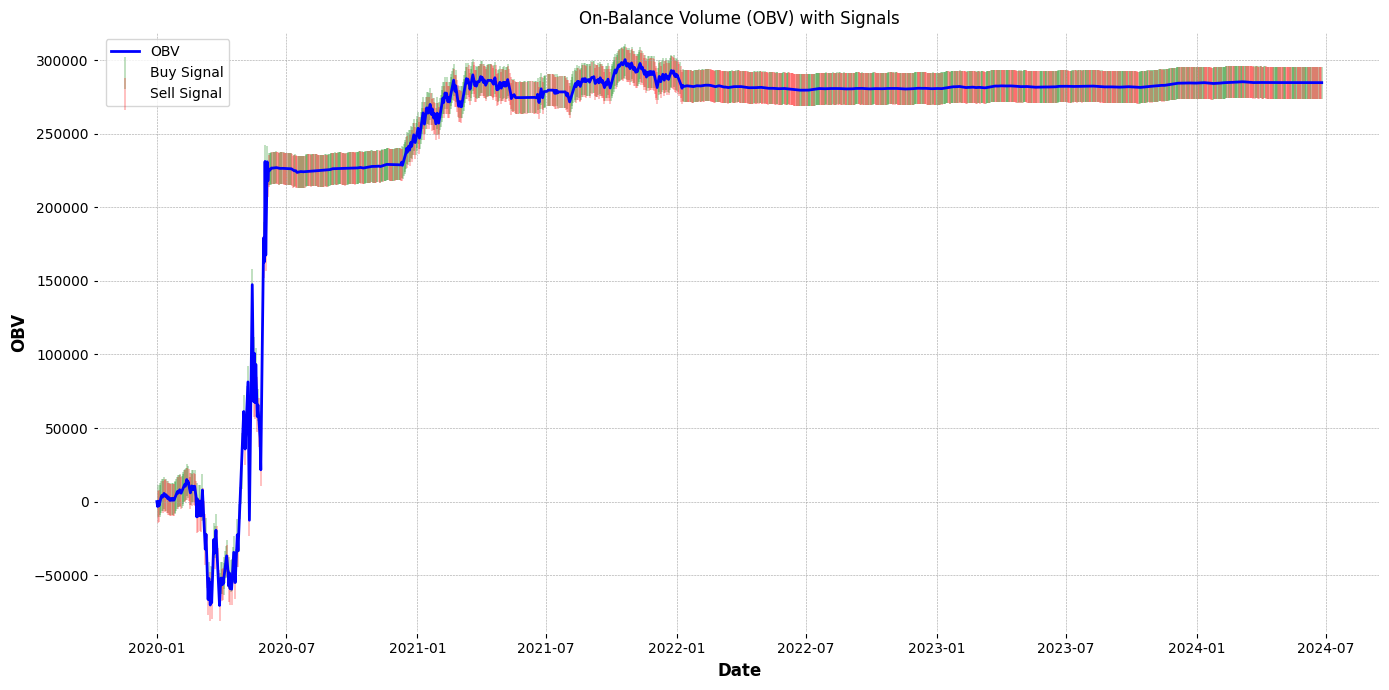

In [125]:
plot_obv_with_signals(BTCUSDT_Filtered_data_with_obv)

### Implementing The Calculation Of Ichimoku Cloud

In [261]:
# Calculate Ichimoku Cloud
BTCUSDT_Filtered_data_1D_with_ichimoku = calculate_ichimoku_cloud(copy.deepcopy(BTCUSDT_Filtered_data_1D))

# Print tThe Data With Ichimoku Results
BTCUSDT_Filtered_data_1D_with_ichimoku

,Open,High,Low,Close,Volume,Tenkan_Sen,Kijun_Sen,Senkou_Span_A,Senkou_Span_B,Chikou_Span
Open time (1D),,,,,,,,,,
2020-01-01,7169.71,9592.00,6871.45,7242.21,50472.792781,8231.725,8231.725,8231.725,8231.725,8885.50
2020-01-02,7242.21,7243.41,6934.53,6975.70,3348.620363,8231.725,8231.725,8231.725,8231.725,8998.68
2020-01-03,6975.70,7600.00,6871.45,7342.00,3584.646061,8231.725,8231.725,8231.725,8231.725,9372.51
2020-01-04,7342.00,7400.00,7260.00,7305.62,3105.244638,8231.725,8231.725,8231.725,8231.725,9498.79
2020-01-05,7305.68,7492.05,7260.00,7438.62,2969.803410,8231.725,8231.725,8231.725,8231.725,9317.71
...,...,...,...,...,...,...,...,...,...,...
2024-06-21,65788.00,71341.20,64100.00,66398.30,16.093789,67720.600,68470.850,68095.725,64156.750,NaN
2024-06-22,66494.90,67625.40,64983.20,65865.00,5.460945,67720.600,68470.850,68095.725,64156.750,NaN
2024-06-23,65806.10,65979.90,64999.50,65400.80,3.795993,67720.600,68470.850,68095.725,65421.000,NaN


### Plotting The Ichimoku Cloud

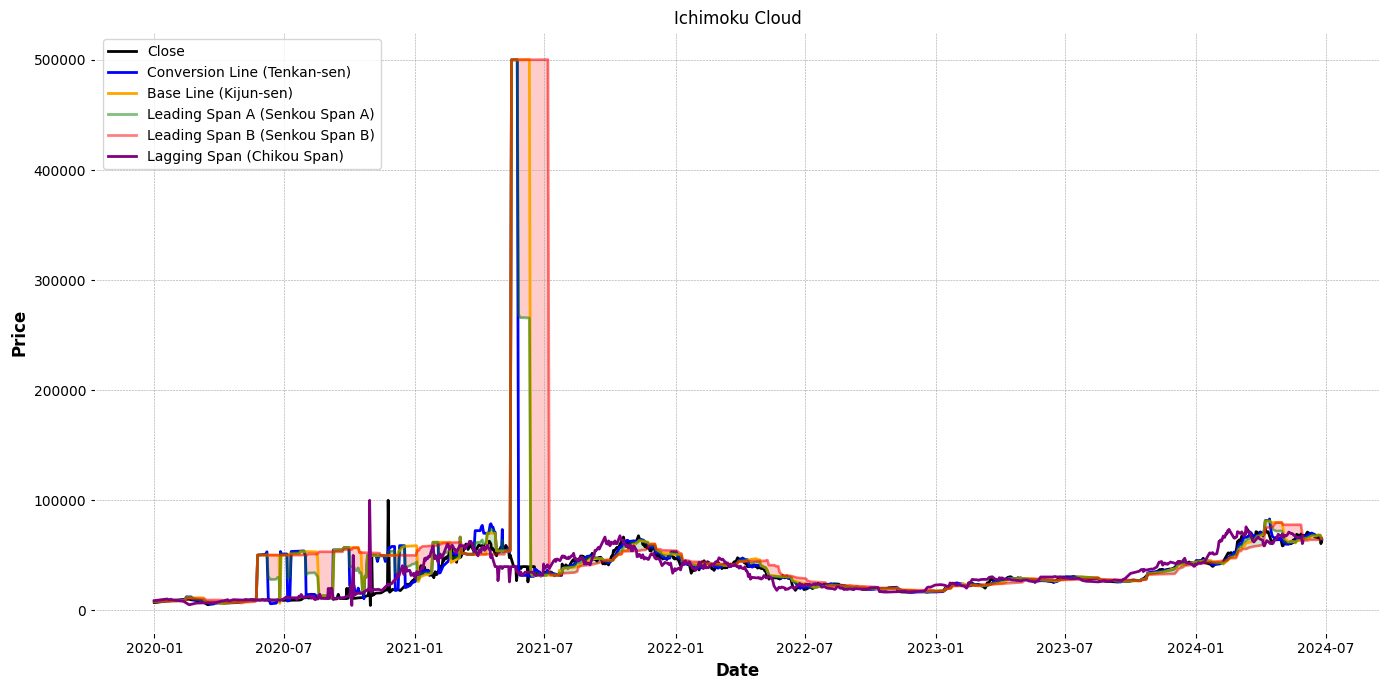

In [262]:
# Plot Ichimoku Cloud
plot_ichimoku_cloud(BTCUSDT_Filtered_data_1D_with_ichimoku)

# ***More Later!***